In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, Activation,Lambda,Multiply
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy,MeanSquaredError
from tensorflow.keras.utils import to_categorical

In [2]:
data = pd.read_csv("D:/过渡/zj/深度学习模型/TCGA训练集.csv")

data['target'] = data['ssrisk'].map({'low': 0, 'high': 1})
data


,Unnamed: 0,MPEG1,PLAUR,score,risk,ssrisk,target
0,TCGA-B2-4101-01A,4.722377,2.177188,0.046879,low,high,1
1,TCGA-BP-4342-01A,3.653921,2.454409,0.502013,high,low,0
2,TCGA-B0-4691-01A,2.396380,2.848564,1.078755,high,low,0
3,TCGA-BP-4167-01A,4.328305,2.513032,0.356070,high,high,1
4,TCGA-B8-4620-01A,3.964925,4.708160,1.781872,high,high,1
...,...,...,...,...,...,...,...
602,TCGA-CJ-6033-01A,3.307191,3.226849,1.062610,high,high,1
603,TCGA-BP-4782-01A,4.043296,2.245836,0.271084,low,high,1
604,TCGA-CJ-4895-01A,3.630476,2.888714,0.771074,high,high,1
605,TCGA-CJ-4640-01A,4.821768,2.138237,-0.003422,low,high,1


In [3]:
#分离特征和标签
X = data.iloc[:,[1,2]]
y = data.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.1,random_state=12,stratify = y, shuffle=True)#
print(X_train.shape)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# y_train = to_categorical(y_train)
# y_valid = to_categorical(y_valid)

# X_train_tensor = torch.tensor(X_train.values,dtype = torch.float32)
# y_valid_tensor = torch.tensor(y_valid.values,dtype = torch.float32)

(546, 2)


In [4]:
data2 = pd.read_csv("GSE36895验证集.csv")
data2['target'] = data2['ssrisk'].map({'low': 0, 'high': 1})

X = data2.iloc[:,[1,2]]
y = data2.iloc[:,-1]

X_test = data2.iloc[:,[1,2]]
y_test = data2.iloc[:,-1]
X_test = scaler.fit_transform(X_test)
# X_test_tensor = torch.tensor(X_test.values,dtype = torch.float32)
# y_test_tensor = torch.tensor(y_test.values,dtype = torch.float32)

In [5]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    
#     attention = Dense(32)(inputs)
#     attention = Activation('relu')(attention)  # 使用小写的'relu'
    attention = Dense(16)(inputs)
    attention = Activation('relu')(attention)  # 使用小写的'relu'
    attention = Dense(8)(attention)
    attention = Activation('relu')(attention)
    attention = Dense(2)(attention)
    attention_weights = Activation('sigmoid')(attention)
    
    
    weighted_features = inputs * attention_weights
    
    
    # 分类器
    x = Dropout(0.5)(weighted_features)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = LeakyReLU()(x)
    x = Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = LeakyReLU()(x)
    outputs = Dense(1, activation='sigmoid')(x)  # 输出单个值，使用sigmoid激活函数
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (X_train.shape[1],)
model = build_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0005), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 定义 ModelCheckpoint 回调
checkpoint = ModelCheckpoint(
    'best_model3.h5',  # 模型文件的保存路径
    monitor='val_accuracy',  # 监控的指标
    save_best_only=True,  # 仅保存最佳模型
    mode='max',  # 最大化 val_accuracy
    verbose=1  # 输出保存的日志信息
)

# 训练模型时使用 ModelCheckpoint 回调
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint]
)

Epoch 1/100
30/35 [========================>.....] - ETA: 0s - loss: 0.8485 - accuracy: 0.4583
Epoch 1: val_accuracy improved from -inf to 0.49180, saving model to best_model3.h5
35/35 [==============================] - 3s 20ms/step - loss: 0.8484 - accuracy: 0.4597 - val_loss: 0.8357 - val_accuracy: 0.4918
Epoch 2/100
18/35 [==============>...............] - ETA: 0s - loss: 0.8364 - accuracy: 0.4514
Epoch 2: val_accuracy did not improve from 0.49180
35/35 [==============================] - 0s 4ms/step - loss: 0.8334 - accuracy: 0.4597 - val_loss: 0.8220 - val_accuracy: 0.4918
Epoch 3/100
19/35 [===============>..............] - ETA: 0s - loss: 0.8207 - accuracy: 0.4901
Epoch 3: val_accuracy did not improve from 0.49180
35/35 [==============================] - 0s 4ms/step - loss: 0.8175 - accuracy: 0.4982 - val_loss: 0.8095 - val_accuracy: 0.4918
Epoch 4/100
18/35 [==============>...............] - ETA: 0s - loss: 0.8114 - accuracy: 0.5174
Epoch 4: val_accuracy improved from 0.49180 to

35/35 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.7051 - val_loss: 0.5471 - val_accuracy: 0.8689
Epoch 30/100
19/35 [===============>..............] - ETA: 0s - loss: 0.6473 - accuracy: 0.6447
Epoch 30: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6535 - accuracy: 0.6447 - val_loss: 0.5442 - val_accuracy: 0.8689
Epoch 31/100
20/35 [================>.............] - ETA: 0s - loss: 0.6094 - accuracy: 0.7000
Epoch 31: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.6886 - val_loss: 0.5408 - val_accuracy: 0.8525
Epoch 32/100
19/35 [===============>..............] - ETA: 0s - loss: 0.6354 - accuracy: 0.6941
Epoch 32: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6832 - val_loss: 0.5427 - val_accuracy: 0.8525
Epoch 33/100
35/35 [====================

19/35 [===============>..............] - ETA: 0s - loss: 0.6315 - accuracy: 0.6612
Epoch 59: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6238 - accuracy: 0.6813 - val_loss: 0.5247 - val_accuracy: 0.8689
Epoch 60/100
21/35 [=================>............] - ETA: 0s - loss: 0.6280 - accuracy: 0.6756
Epoch 60: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6703 - val_loss: 0.5285 - val_accuracy: 0.8689
Epoch 61/100
19/35 [===============>..............] - ETA: 0s - loss: 0.6350 - accuracy: 0.6776
Epoch 61: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6832 - val_loss: 0.5284 - val_accuracy: 0.8689
Epoch 62/100
19/35 [===============>..............] - ETA: 0s - loss: 0.6518 - accuracy: 0.6382
Epoch 62: val_accuracy did not improve from 0.90164
35/35 [===========================

Epoch 89/100
35/35 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.6465
Epoch 89: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6465 - val_loss: 0.5211 - val_accuracy: 0.8525
Epoch 90/100
20/35 [================>.............] - ETA: 0s - loss: 0.6370 - accuracy: 0.6375
Epoch 90: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6465 - val_loss: 0.5253 - val_accuracy: 0.8525
Epoch 91/100
19/35 [===============>..............] - ETA: 0s - loss: 0.6424 - accuracy: 0.6250
Epoch 91: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6575 - val_loss: 0.5286 - val_accuracy: 0.8525
Epoch 92/100
18/35 [==============>...............] - ETA: 0s - loss: 0.6345 - accuracy: 0.6562
Epoch 92: val_accuracy did not improve from 0.90164
35/35 [==============

In [9]:
from tensorflow.keras.models import load_model

# 加载保存的模型
best_model = load_model('best_model3.h5')



def capacity(X_valid,y_valid):
    y_predictions = best_model.predict(X_valid)
    y_pred = (y_predictions > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    fpr, tpr, thresholds = roc_curve(y_valid, y_predictions)
    auc = roc_auc_score(y_valid, y_predictions)
    print("Accurac:",accuracy_score(y_valid,y_pred))
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    return fpr, tpr, auc
    

In [16]:
print("TCGA validation set:")
fpr1, tpr1, auc1 = capacity(X_valid,y_valid)

TCGA validation set:
2/2 [==============================] - 0s 6ms/step
Accurac: 0.9016393442622951
Sensitivity: 0.9666666666666667
Specificity: 0.8387096774193549


In [11]:
print("GSE36895 test set:")
fpr2, tpr2, auc2 = capacity(X_test,y_test)

GSE36895 test set:
3/3 [==============================] - 0s 5ms/step
Accurac: 0.8421052631578947
Sensitivity: 0.7631578947368421
Specificity: 0.9210526315789473


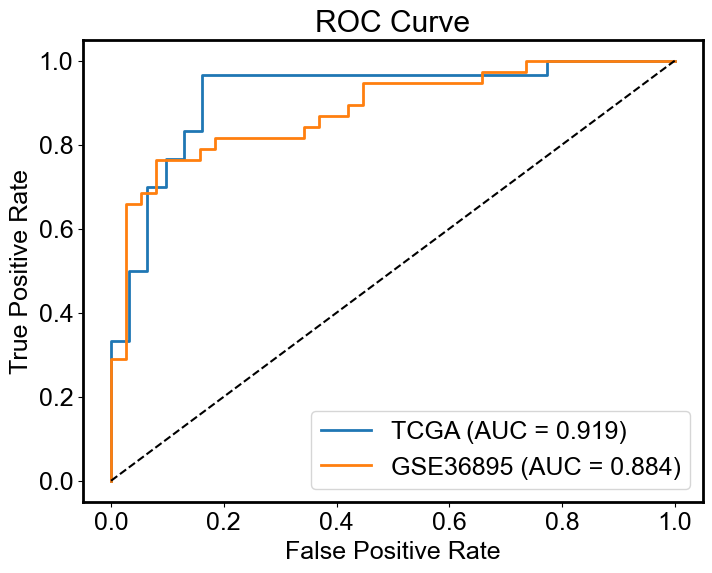

In [12]:
# 计算ROC曲线和AUC
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18

# 创建图形对象
plt.figure(figsize=(8, 6))

# 绘制 ROC 曲线
plt.plot(fpr1, tpr1, label='TCGA (AUC = {:.3f})'.format(auc1),linewidth=2)
plt.plot(fpr2, tpr2, label='GSE36895 (AUC = {:.3f})'.format(auc2),linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')

# 设置标签、标题和图例
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# 获取当前坐标轴对象
ax = plt.gca()

# 修改边框属性
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')

# 保存图像
plt.savefig('roc_curve.pdf', dpi=300, bbox_inches='tight')

# 显示图像
plt.show()